A steel manufacturing company has aked that image segmentation be used to detect and localize defects on the steel surface.
The team gathered 12600 that contain 4 types of defects along with their location on the steel surface.

Image segmentation is a used to understand and extract information from pictures on the pixel level.
The goal of the image segmentation is to train the neural network to produce pixel-wise mask of the image.
The techniques used are Convolutional neural networks(CNN), FCN(Fully convolutional networks) and deep encoders-decoders.

In [22]:
#import libraries and dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from skimage import io
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
# data containing defect images with segmentation mask 
defect_class_mask_df = pd.read_csv(r"C:\Users\abarr\Desktop\train.csv")

In [3]:
# data containing defective and non defective images
all_images_df = pd.read_csv(r"C:\Users\abarr\Desktop\defect_and_no_defect.csv")

In [4]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [5]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [6]:
#VISUALIZE AND EXPLORE DATASET
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)
defect_class_mask_df.head(10)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


C:\Users\abarr\.conda\envs\Tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


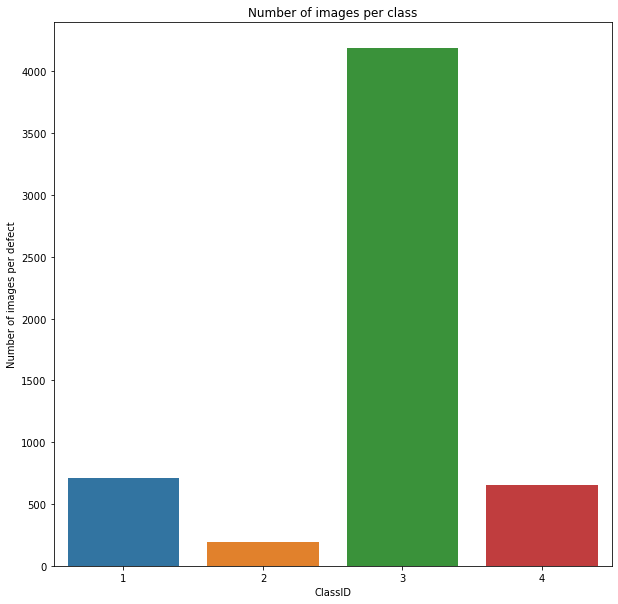

In [7]:
plt.figure(figsize=(10,10))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class');

In [9]:
# Some images are classified with more than one defect, let's explore this futher
# we have one image with 3 types of defects 
# we have 272 images with 2 types of defects
# we have 5201 images with 1 type of defect
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [10]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

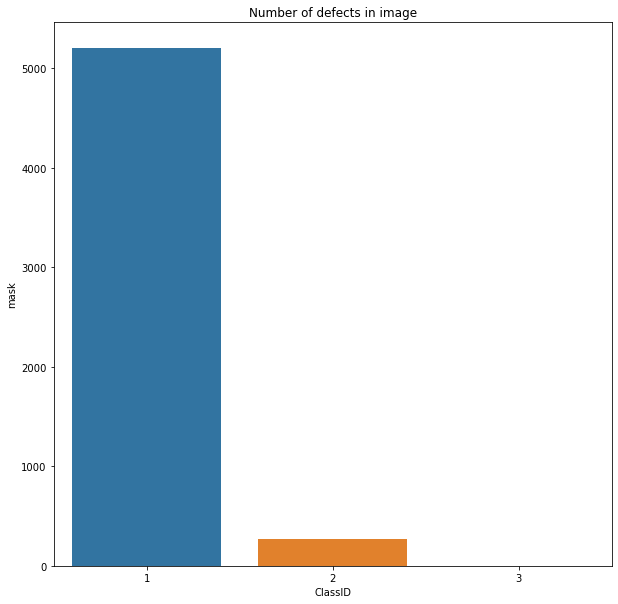

In [11]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image');

In [12]:
defect_class_mask_df.shape

(5748, 4)

In [13]:
all_images_df.shape

(12997, 2)

In [14]:
# Let's count defective and non defective images
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

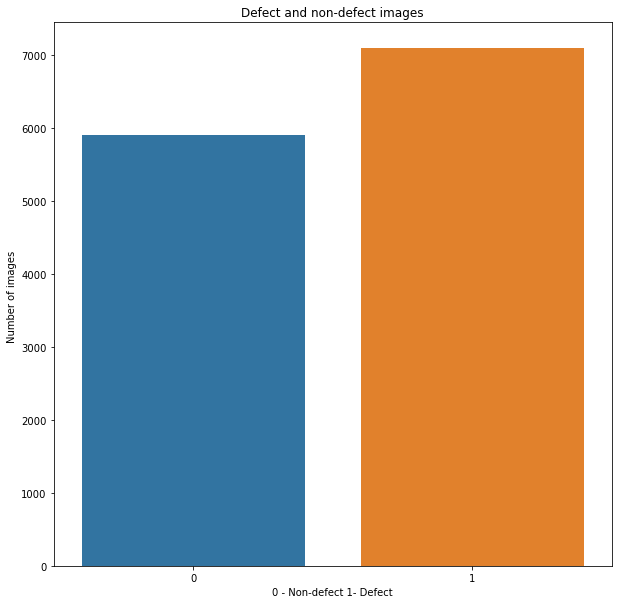

In [15]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect 1- Defect')
plt.title('Defect and non-defect images');

In [25]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600
train_dir = r"C:\Users\abarr\Downloads\6. Maintenance Department-20220718T154519Z-001\6. Maintenance Department\train_images"

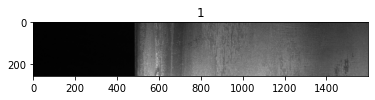

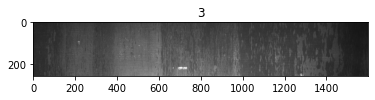

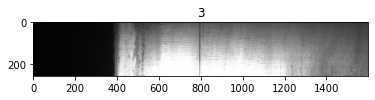

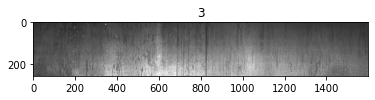

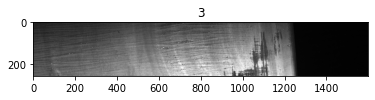

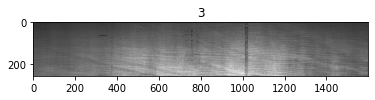

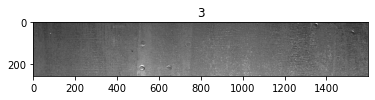

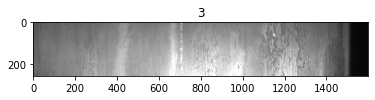

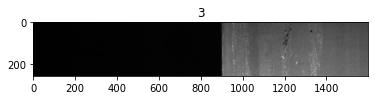

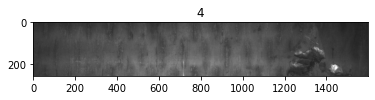

In [26]:
for i in range(10):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)

In [28]:
# Utilities file contains the code for rle2mask, mask2rle, custom loss function and custom data generator
# since the data provided for segmentation is in RLE format (run length encoded), we will be using the following function to convert the RLE to mask. 
# we can convert the mask back again to RLE to assess model performance (accuracy).
import rle2mask , mask2rle

train_dir = r"C:\Users\abarr\Downloads\6. Maintenance Department-20220718T154519Z-001\6. Maintenance Department\train_images"

ModuleNotFoundError: No module named 'rle2mask'